# Classification - Doc2Vec

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Doc2Vec](https://radimrehurek.com/gensim_3.8.3/models/doc2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

def get_X():
     return np.vstack([document.text for document in documents])

y = get_y()
X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import doc2vec

In [4]:
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
preprocessing = PreprocessingDefinition('doc2vec', 'basic', 'basic', 'english', '1,1', 'None')
paths = available_classifier_paths('doc2vec')

def create_classifier(classifier, name, vector_size=100):
    path = [path for path in paths if name in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_ = doc2vec(X_train, X_test, y, vector_size=vector_size)
        clf.fit(X_train_, y_train)
        clf.score(X_test_, y_test)
        clf.save('doc2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [5]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 98.82530164718628s
Test: 0.06120729446411133s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02490803793037612      0.0015719467956469165    0.08070737605804112      0.07757758968158         0.07223584959981573      
micro                                                            0.07862043389579083      0.08092375226643764      0.0797554667293675       
macro                                                            0.024181495264812156     0.024865759942004354     0.024424724523169603     


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 0.9687104225158691s
Test: 78.79663872718811s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013661299560873162     0.03712212817412334      0.05481660620717452      0.02393994357114067      0.03177347843611447      
micro                                                            0.33066666666666666      0.023666380379807235     0.044171342060735606     
macro                                                            0.07181691481630402      0.005487487114684059     0.009575460667928703     


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [9]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 133.19925093650818s
Test: 0.09873771667480469s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013220899891809329     0.04062877871825877      0.08855098750503829      0.04068117694478033      0.0525741348534577       
micro                                                            0.5605263157894737       0.04065273403950759      0.07580745617937538      
macro                                                            0.12031748202518171      0.014398125158605867     0.02321399605364321      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 1376.9848029613495s
Test: 0.7255492210388184s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013243174441545217     0.03954050785973398      0.037081821846029824     0.0150080612656187       0.02045430989808257      
micro                                                            0.6457925636007827       0.015745777268823362     0.03074200009315758      
macro                                                            0.050104740585900226     0.0037645184167432342    0.006551694923389184     


In [11]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 67.48622488975525s
Test: 0.9065883159637451s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013279450136829378     0.039298669891172915     0.05685034836183566      0.026866182990729542     0.03394560565056333      
micro                                                            0.5425138632162662       0.028008397747876706     0.05326678765880218      
macro                                                            0.09813752410722539      0.00939566408780324      0.015825306405464597     


<a id='classwise'/>

**Classwise Classifier**

In [12]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

scorer = make_scorer(accuracy_score)

In [13]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption

classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                      ClassifierOption(LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], random_state=RANDOM_STATE, max_iter=2000, scoring=scorer))]
                      #ClassifierOption(RandomForestClassifier(random_state=RANDOM_STATE))]

#create_classifier(ClasswiseClassifier(classifier_options), 'ClasswiseClassifier')

<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [14]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 895.6085774898529s
Test: 2.386582374572754s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013211990071914976     0.04050785973397823      0.046150745667069726     0.01948609431680774      0.026143260206138073     
micro                                                            0.6576433121019108       0.0197060788243153       0.03826554248123784      
macro                                                            0.0673369301934129       0.005980423771776812     0.00996629533539367      


In [15]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 101.02004194259644s
Test: 2.5651907920837402s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013287723541016993     0.04062877871825877      0.06132271933360204      0.02983474405481661      0.0372981029450195       
micro                                                            0.5327257663628832       0.03068040843591946      0.058019399954883824     
macro                                                            0.10519782763735347      0.010710803326947776     0.018228189755284886     


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [16]:
from skmultilearn.problem_transform import LabelPowerset

create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

Training: 4070.588180065155s
Test: 1.5646648406982422s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.019495322344555463     0.01608222490931076      0.2354675534058847       0.1305844417573559       0.15257058405788754      
micro                                                            0.17704786701381936      0.1265387918694532       0.14759161866599885      
macro                                                            0.05127947754472457      0.04158938447935515      0.04312067324109735      


In [17]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [18]:
from skmultilearn.adapt import MLkNN

#create_classifier(MLkNN(), 'MLkNN')

<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [22]:
from skmultilearn.adapt import MLARAM

#create_classifier(MLARAM(), 'MLARAM')

<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [25]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 4569.950880765915s
Test: 122.11617064476013s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012939604149430408     0.04691656590084643      0.10542926239419588      0.05010882708585248      0.06408533425462083      
micro                                                            0.6810845706907682       0.05049538122816254      0.09402014080741468      
macro                                                            0.14391943252200118      0.013723442491285608     0.022882186591055124     


In [26]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 499.07825565338135s
Test: 129.6031084060669s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01299051740596958      0.04873035066505441      0.16575374578397556      0.09182587666263602      0.10908189888842851      
micro                                                            0.5709648863971674       0.0926147513521275       0.15937731653076354      
macro                                                            0.25481736726349635      0.04560571822726606      0.07207915114008932      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [27]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 1521.2948400974274s
Test: 37.0413761138916s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012940240565137148     0.045707376058041115     0.1058000806126562       0.05063885530028214      0.06459895203546957      
micro                                                            0.6754385964912281       0.05159622840185708      0.09586909155587177      
macro                                                            0.1535457187221468       0.01602798547932414      0.026464791142804638     


In [28]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 98.63284397125244s
Test: 38.4376425743103s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013017246865652645     0.049576783555018135     0.1676252942274708       0.0941596130592503       0.11106826802110963      
micro                                                            0.5614673760851302       0.09596515579380654      0.163914323086985        
macro                                                            0.2613822322922186       0.04769411635781605      0.07493665985774767      


***Clustering***

In [29]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

label_names = get_all_labels()

edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))

190 labels, 7733 edges


In [30]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_train, y_train)
print(partition)

colors = ['red', 'white', 'blue']
membership_vector = to_membership_vector(partition)
visual_style = {
    "vertex_size" : 20,
    "vertex_label": [x[0] for x in label_names],
    "edge_width" : [10*x/y_train.shape[0] for x in clusterer_igraph.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(y_train.shape[1])],
    "bbox": (400,400),
    "margin": 80,
    "layout": clusterer_igraph.graph_.layout_circle()

}

#ig.plot(clusterer_igraph.graph_, **visual_style)

[list([0, 1, 3, 6, 7, 11, 14, 17, 19, 24, 25, 26, 27, 30, 31, 32, 36, 41, 44, 46, 50, 51, 58, 59, 63, 70, 75, 76, 77, 80, 88, 89, 90, 91, 95, 96, 97, 98, 99, 104, 110, 111, 112, 113, 114, 115, 116, 117, 120, 123, 124, 125, 132, 133, 134, 137, 139, 141, 142, 143, 145, 150, 152, 154, 156, 158, 166, 167, 172, 175, 183, 184, 187, 188, 189])
 list([2, 4, 5, 8, 9, 10, 12, 13, 15, 16, 18, 20, 21, 22, 23, 28, 29, 33, 34, 35, 37, 38, 39, 40, 42, 43, 45, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 78, 79, 81, 82, 83, 84, 85, 86, 87, 92, 93, 94, 100, 101, 102, 103, 105, 106, 107, 108, 109, 118, 119, 121, 122, 126, 127, 128, 129, 130, 131, 135, 136, 138, 140, 144, 146, 147, 148, 149, 151, 153, 155, 157, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 173, 174, 176, 177, 178, 179, 180, 181, 182, 185, 186])]


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [31]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 100.39254021644592s
Test: 5.097863435745239s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013044612741042448     0.05030229746070133      0.15102614502251746      0.08716646513502618      0.10134646355928098      
micro                                                            0.5597465298732649       0.08878571770449432      0.15326145329863264      
macro                                                            0.25605236516358465      0.0439489524659337       0.07010727023392814      


In [32]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 803.2592420578003s
Test: 5.587182998657227s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012831413479284669     0.04836759371221282      0.12150947198710196      0.06085247883917775      0.07620487130765245      
micro                                                            0.7031684269038355       0.060546594553199634     0.11149303719372465      
macro                                                            0.21701318950550635      0.02777848837341382      0.043784685447169555     


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [33]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 99.03382539749146s
Test: 2.0146703720092773s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013044612741042448     0.05030229746070133      0.15102614502251746      0.08716646513502618      0.10134646355928098      
micro                                                            0.5597465298732649       0.08878571770449432      0.15326145329863264      
macro                                                            0.25605236516358465      0.0439489524659337       0.07010727023392814      


In [34]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 799.017716884613s
Test: 1.9917166233062744s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012831413479284669     0.04836759371221282      0.12150947198710196      0.06085247883917775      0.07620487130765245      
micro                                                            0.7031684269038355       0.060546594553199634     0.11149303719372465      
macro                                                            0.21701318950550635      0.02777848837341382      0.043784685447169555     


<a id='evaluation'/>

## Evaluation

In [35]:
paths = available_classifier_paths('doc2vec')
evals = []
paths = [path for path in paths if '-' not in path.name]
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

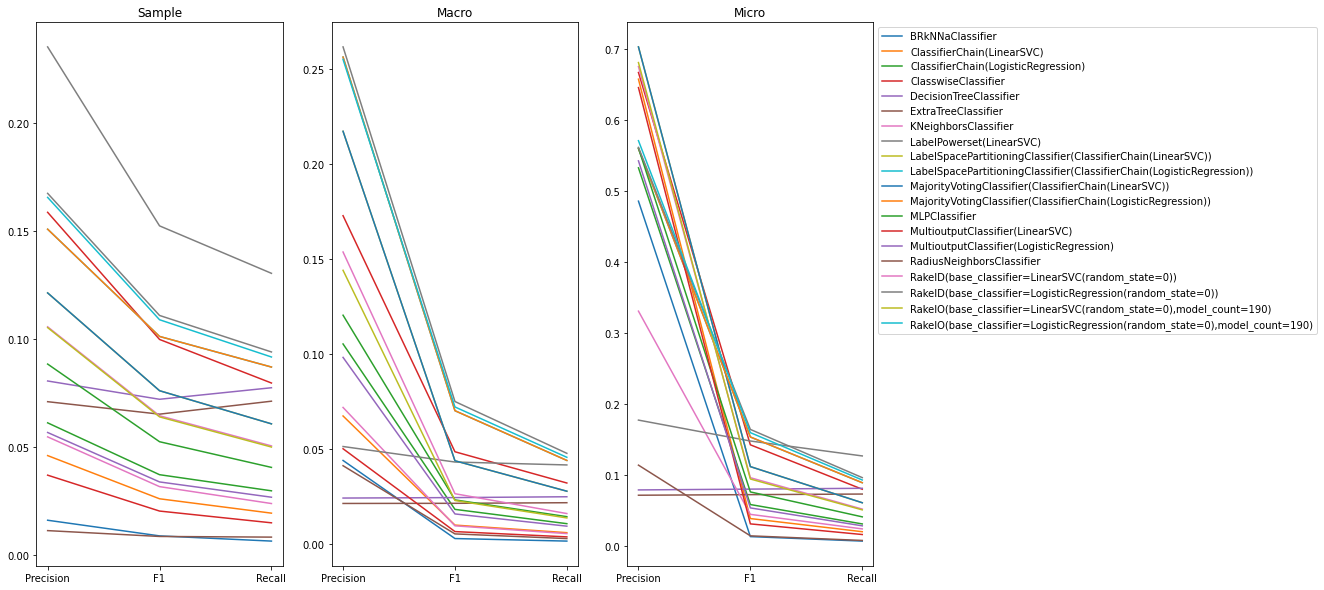

In [36]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [37]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [38]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray() 
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [39]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_ = doc2vec(X_train, X_test, y)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

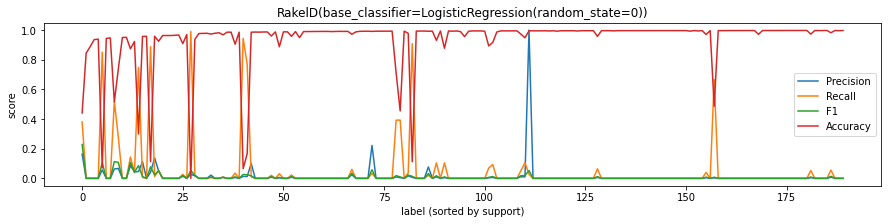

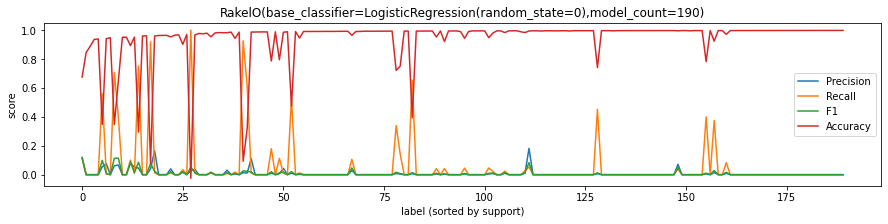

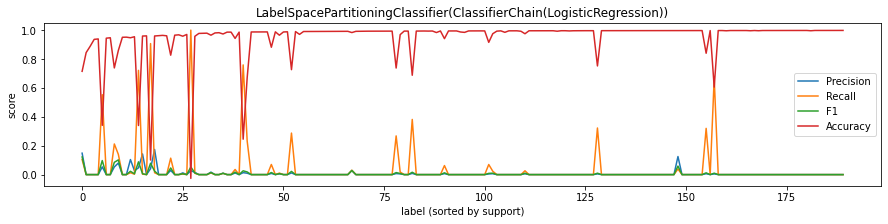

In [40]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [41]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-100', 100)

Training: 83.03754186630249s
Test: 0.9404819011688232s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013264812575574365     0.046553808948004836     0.05487101975010076      0.025721483272873838     0.03250983666340378      
micro                                                            0.5393474088291746       0.026857825567502987     0.051167660581781765     
macro                                                            0.11064299118692687      0.009219535018711743     0.015849922768181843     


In [42]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-200', 200)

Training: 120.43543791770935s
Test: 1.6785261631011963s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013341182460383122     0.04425634824667473      0.03619677514477999      0.017708585247883917     0.022238746071877875     
micro                                                            0.4763092269326683       0.01825567502986858      0.03516362130068578      
macro                                                            0.11532267916939075      0.009104257710937098     0.0155643842724015       


In [43]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-500', 500)

Training: 298.24828839302063s
Test: 4.5335047245025635s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013248265767199134     0.04788391777509069      0.06235989625046457      0.031515517936316004     0.03894157501775398      
micro                                                            0.5447019867549668       0.03144563918757467      0.05945872678805402      
macro                                                            0.11818427968964221      0.009510874954070582     0.016549324456990457     


In [44]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-1000', 1000)

Training: 433.76030921936035s
Test: 8.370611190795898s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013234264621650862     0.04691656590084643      0.06657108308861635      0.03238814993954051      0.04052033550219765      
micro                                                            0.5525040387722132       0.032688172043010756     0.06172449578125705      
macro                                                            0.13074697361836646      0.013820612760659495     0.023224251457069554     


In [45]:
paths = available_classifier_paths('doc2vec')
multi_names = ['MultioutputClassifier(LogisticRegression)-']
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)-' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([int(str(clf.name_prefix).strip('MultioutputClassifier(LogisticRegression)-')), evaluation])

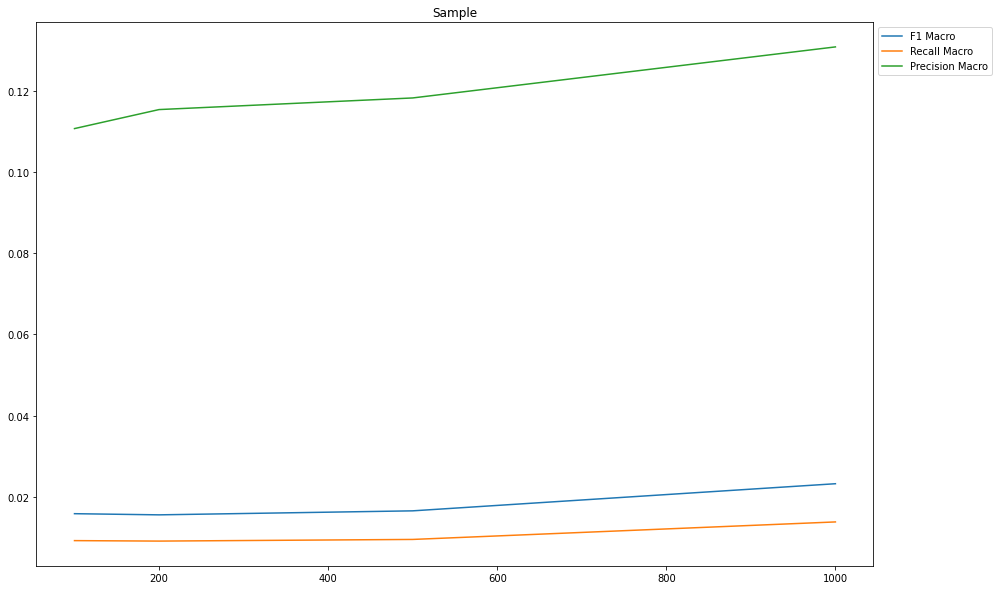

In [46]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()